In [23]:
import os
import logging
import json
from time import sleep
from IPython.core.display import display, HTML, Image

# Little helpers

def printAsHtmlTable(objList, keys):
    htmlRows = []
    htmlRows.append("<table>")
    htmlRows.append("<tbody>")
    
    htmlRows.append("<tr>")
    for k in keys:
        htmlRows.append("<th>")
        htmlRows.append(k)
        htmlRows.append("</th>")
    htmlRows.append("</tr>")
        
    for obj in objList:
        htmlRows.append("<tr>")
        for k in keys:
            htmlRows.append("<td>")
            htmlRows.append(obj.get(k, "<i>[NULL]</i>"))
            htmlRows.append("</td>")
        htmlRows.append("</tr>")
    htmlRows.append("</tbody>")
    htmlRows.append("</table>")
    
    display(HTML('\n'.join(htmlRows)))
    
def printDevices(devices):
    printAsHtmlTable(devices, ["Id", "Model", "Name", "Status"])

#### Getting credentials and codes
When the notebook is exported, these values are taken from config.json
```
$ cat config.json
{
  "AVS_USERNAME": "test_username",
  "AVS_PASSWORD": "test_password",
  "AVS_PAIRING_CODE": "9999-1111"
}

$ jupyter nbconvert --to html --execute device_api.ipynb --ExecutePreprocessor.timeout=-1
```

Otherwise, if the notebook is used in interactive mode, set up those values right in the code below.

In [25]:
configFilename = "config.json"
if os.path.isfile(configFilename):
    with open(configFilename) as f:
        cfg = json.load(f)

        kAVSUsername = cfg["AVS_USERNAME"]
        kAVSPassword = cfg["AVS_PASSWORD"]
        kPairingCode = cfg["AVS_PAIRING_CODE"]
else:
    kAVSUsername = "test_username"
    kAVSPassword = "test_password"
    kPairingCode = "9999-1111"

#### Importing AV Studio API

In [26]:
from avstudio.avstudio import AVStudioAPI

# Establishing connection to AV Studio

In [27]:
api = AVStudioAPI("go.avstudio.com")

In [28]:
if False:
    logger = logging.getLogger("avstudio")
    logging.basicConfig()
    logger.setLevel(logging.DEBUG)

In [32]:
api.login(kAVSUsername, kAVSPassword)
allDevices = api.Devices.get_all()
    
printDevices(allDevices)

Id,Model,Name,Status
demo_0_0ce4234e-388b-4380-a5db-93c2911926d1,Demo,My First Demo Device,Online
demo_1_277249bb-5ace-49a7-8e5c-9c2fc27df344,Demo,My Second Demo Device,Online


# Pairing device to AV Studio:

In [159]:
deviceId = api.Devices.add(kPairingCode, "Webcaster on my desk")["ID"]

In [160]:
printDevices(api.Devices.get_all())

Id,Model,Name,Status
e74196b56b4f4be6bf85cee08faec9b5,WCX2,Webcaster on my desk,Online


# Getting current image from the device

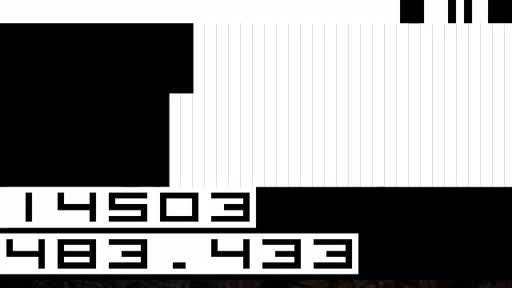

In [161]:
tmpImagePath = "/tmp/image_%s.jpg" % deviceId
api.Devices.get_state_image(deviceId, tmpImagePath)
Image(tmpImagePath)

# Setting stream parameters

In [164]:
api.Devices.run_command(deviceId, "setparam:bitrate=%d" % 1024)  # 1 Mbit/s
api.Devices.run_command(deviceId, 'setparam:resolution=%s' % "640x360")

devTelemetry = api.Devices.get(deviceId)["Telemetry"]
if "settings" in devTelemetry:
    printAsHtmlTable(devTelemetry["settings"].values(), ["id", "title", "value"])

# Streaming to RTMP

In [145]:
streamKey = "ENTER-STREAM-KEY-HERE"  # youtube.com/live_dashboard
url = "rtmp://a.rtmp.youtube.com/live2/%s" % streamKey
_ = api.Devices.run_command(deviceId, "rtmp.start:%s" % url)

In [146]:
# Let it stream a little
streamId = "ENTER-PUBLIC-STREAM-ID-HERE"
display(HTML('<iframe width="560" height="315" src="https://www.youtube.com/embed/%s" frameborder="0" allow="autoplay; encrypted-media" allowfullscreen></iframe>' % streamId))

In [147]:
_ = api.Devices.run_command(deviceId, "rtmp.stop")

# Unpairing the device:

In [165]:
api.Devices.delete(deviceId)
printDevices(api.Devices.get_all())

Id,Model,Name,Status
